In [211]:
import cirq
import numpy as np

In [212]:
def H_p(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
            HCircuit.append(cirq.rz(gamma * C[i][j])(cirq.LineQubit(j)))
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
    return HCircuit

def H_d(N, beta):
    dCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(N):
        dCircuit.append(cirq.rx(beta)(cirq.LineQubit(i)))
    return dCircuit

def H_pZZ(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (gamma*C[i][j]))
    return HCircuit

In [213]:
def f(x):
    return 1 - (1-x)**2

                        ┌────────┐   ┌────────┐   ┌────────┐                                                      ┌────────────────┐   ┌────────────────┐   ┌─────────────────┐                                                                ┌─────────────────┐   ┌────────────────┐   ┌────────────────┐                                                                 ┌────────────────┐   ┌───────────────┐   ┌───────────────────┐                                                             ┌────────────────┐   ┌────────────────┐   ┌─────────────────┐
0: ───H───ZZ─────ZZ──────ZZ───────────ZZ─────────────────────────────────────Rx(-0.637π)───ZZ──────────ZZ──────────ZZ───────────────────ZZ────────────────────────────────────────────────────────────────Rx(-0.591π)───ZZ───────────ZZ─────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────Rx(-0.555π)───ZZ──────────ZZ─────────ZZ───────────────────ZZ─────────────────────────────────────────────────────────────

/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

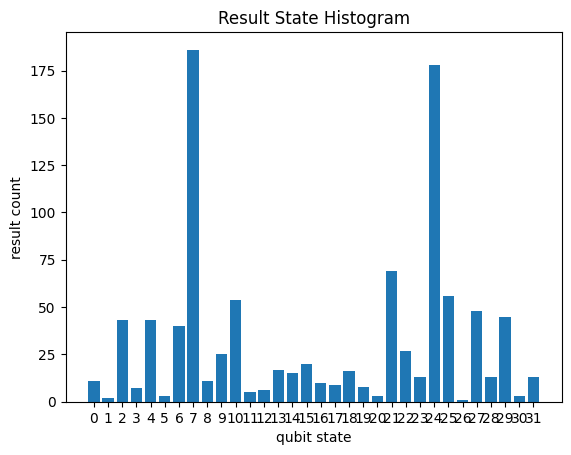

In [214]:
#################################TEST#############################################
costMat = [[0, .12, .05, .83, .76],
           [0, 0, .09, .95, .69],
           [0, 0, 0, .98, .87],
           [0, 0, 0, 0, .12],
           [0, 0, 0, 0, 0],]
costMat = np.array(costMat)
for i in range(len(costMat)):
    for j in range(len(costMat)):
        costMat[i][j] = costMat[i][j] * 100

N = 5

testCircuit = cirq.Circuit()
testQubits = cirq.LineQubit.range(N)

testCircuit.append(cirq.H.on_each(*testQubits))

T = 1.0
numIterations = 20
dt = .2

for t in np.arange(0, T, dt):
    d = 1 - f(t/T)
    pAngle = (-2 * f(t/T) * dt)
    dAngle = (-2 * (1 - f(t/T) * dt))   #this angle for the driver hamiltonian is basically equivalent to setting it to a constant value

    testCircuit.append(H_pZZ(costMat, pAngle, N))   #for some reason using the normal H_p doesn't work
    testCircuit.append(H_d(N, dAngle))

testCircuit.append(cirq.measure(*testQubits, key='z'))
print(testCircuit)


counts = 1000

simulator = cirq.Simulator()
samples =  simulator.run(testCircuit, repetitions=counts)

data = samples.histogram(key='z')
cirq.plot_state_histogram(data)

##################################TEST############################################
#correct answer should be 7 or 24


In [215]:
def singleGateError(circuit, qubit):
    prob = np.random.random()
    if prob < 0.0005:
        print("singleGateError ", prob)
        gate = np.random.choice(range(3))
        if gate == 0:
            circuit.append(cirq.X(qubit))
        if gate == 1:
            circuit.append(cirq.Y(qubit))
        if gate == 2:
            circuit.append(cirq.Z(qubit))
def CNOTError(circuit, qubits):
    prob = np.random.random()
    if prob < 0.005:
        print("CNOT Error: ", prob)
        gate = np.random.choice(range(3))
        qubit = np.random.choice(range(2))
        if gate == 0:
            circuit.append(cirq.X(qubits[qubit]))
        if gate == 1:
            circuit.append(cirq.Y(qubits[qubit]))
        if gate == 2:
            circuit.append(cirq.Z(qubits[qubit]))

In [216]:
def NoisyH_p(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
            CNOTError(HCircuit, [qubits[i], qubits[j]])
            HCircuit.append(cirq.rz(gamma * C[i][j])(qubits[j]))
            singleGateError(HCircuit, qubits[j])
            HCircuit.append(cirq.CNOT(qubits[i], qubits[j]))
            CNOTError(HCircuit, [qubits[i], qubits[j]])
    return HCircuit

def NoisyH_d(N, beta):
    dCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(N):
        dCircuit.append(cirq.rx(beta)(cirq.LineQubit(i)))
        singleGateError(dCircuit, cirq.LineQubit(i))
    return dCircuit

def NoisyH_pZZ(C, gamma, N):
    HCircuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(N)
    for i in range(0, N, 1):
        for j in range(i+1, N, 1):
            HCircuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (gamma*C[i][j]))
            CNOTError(HCircuit, [qubits[i], qubits[j]])
            singleGateError(HCircuit, qubits[j])
            CNOTError(HCircuit, [qubits[i], qubits[j]])
    return HCircuit

singleGateError  4.747661007487025e-05
                        ┌────────┐   ┌────────┐   ┌────────┐                                                      ┌────────────────┐   ┌────────────────┐   ┌─────────────────┐                                                                ┌─────────────────┐   ┌────────────────┐   ┌────────────────┐                                                                 ┌────────────────┐   ┌───────────────┐   ┌───────────────────┐                                                             ┌────────────────┐   ┌────────────────┐
0: ───H───ZZ─────ZZ──────ZZ───────────ZZ─────────────────────────────────────Rx(-0.637π)───ZZ──────────ZZ──────────ZZ───────────────────ZZ────────────────────────────────────────────────────────────────Rx(-0.591π)───ZZ───────────ZZ─────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────Rx(-0.555π)───ZZ──────────ZZ─────────ZZ───────────────────ZZ────────────────────────────────────────────

/home/dumpster-jedi/.local/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

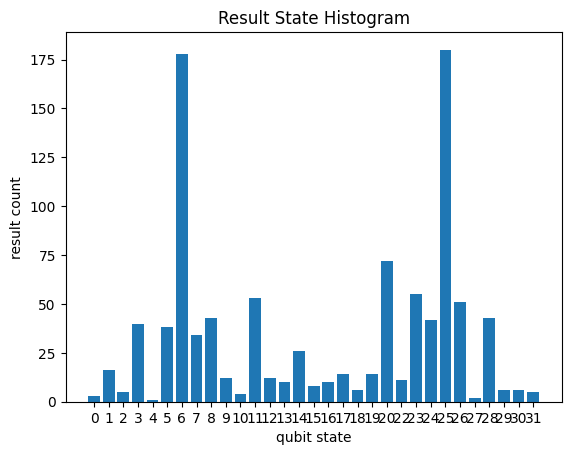

In [217]:
#################################NOISY-TEST#############################################
costMat = [[0, .12, .05, .83, .76],
           [0, 0, .09, .95, .69],
           [0, 0, 0, .98, .87],
           [0, 0, 0, 0, .12],
           [0, 0, 0, 0, 0],]
costMat = np.array(costMat)
for i in range(len(costMat)):
    for j in range(len(costMat)):
        costMat[i][j] = costMat[i][j] * 100

N = 5

testCircuit = cirq.Circuit()
testQubits = cirq.LineQubit.range(N)

testCircuit.append(cirq.H.on_each(*testQubits))

T = 1.0
dt = .2

for t in np.arange(0, T, dt):
    pAngle = (-2 * f(t/T) * dt)
    dAngle = (-2 * (1 - f(t/T) * dt))
    testCircuit.append(NoisyH_pZZ(costMat, pAngle, N))
    testCircuit.append(NoisyH_d(N, dAngle))

testCircuit.append(cirq.measure(*testQubits, key='z'))
print(testCircuit)


counts = 1000

simulator = cirq.Simulator()
samples =  simulator.run(testCircuit, repetitions=counts)

data = samples.histogram(key='z')
cirq.plot_state_histogram(data)

#################################NOISY-TEST#############################################
#correct answer should be 7 or 24
# for some reason this is single error fragile in its current state. 
